# TensorFlow Time Series Predictions

Play with the same data as linear regressions.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import util

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
# Number of days to generate data for
DAYS = 20

df = None
for d in range(0, DAYS):
    print('Day %d' % d)
    if df is not None:
        df = df.append(util.gen_random_data_frame(first_index=d*1440), ignore_index=True)
    else:
        df = util.gen_random_data_frame(first_index=d*1440)
df

Day 0
Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Day 8
Day 9
Day 10
Day 11
Day 12
Day 13
Day 14
Day 15
Day 16
Day 17
Day 18
Day 19


,Time,Security ACEs
0,0,103
1,1,100
2,2,100
3,3,100
4,4,101
...,...,...
28795,28795,100
28796,28796,100
28797,28797,102
28798,28798,103


In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    '''
    * history_size size of past window of information
    * target_size how far in the future to predict
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ef662d0>],
      dtype=object)

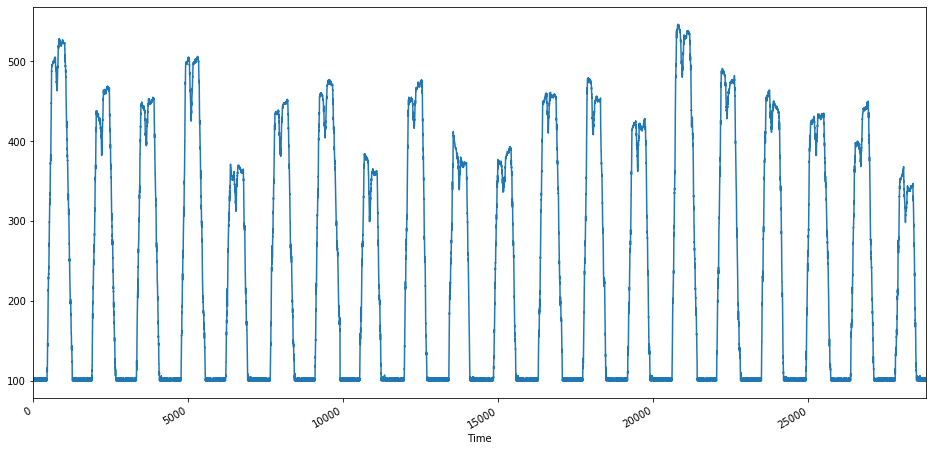

In [4]:
uni_data = df['Security ACEs']
uni_data.index = df['Time']
uni_data.plot(subplots=True)

## Normalize Data

Mean    = 236.984375
Std Dev = 153.05337761540696


array([<matplotlib.axes._subplots.AxesSubplot object at 0x14c6d1110>],
      dtype=object)

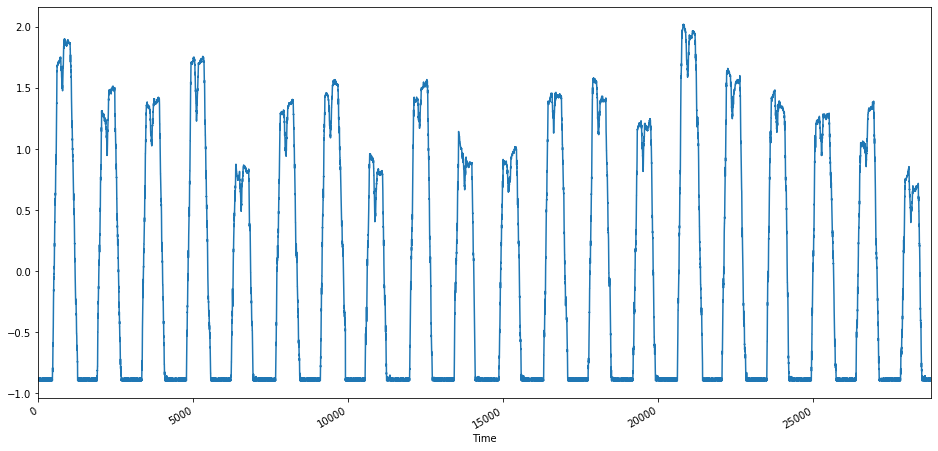

In [5]:
uni_train_mean = uni_data.mean()
uni_train_std = uni_data.std()

print('Mean    = {}'.format(uni_train_mean))
print('Std Dev = {}'.format(uni_train_std))

uni_data = (uni_data-uni_train_mean)/uni_train_std
uni_data.plot(subplots=True)

## Prepare Data

In [6]:
uni_data_vals = uni_data.values

univariate_past_history = 1440
univariate_future_target = 10

x_train_uni, y_train_uni = univariate_data(uni_data_vals, 0, 1440*(DAYS-2),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data_vals, 1440*(DAYS-2), None,
                                       univariate_past_history,
                                       univariate_future_target)

In [7]:
print(x_train_uni.shape)
#print(x_train_uni)
print(y_train_uni.shape)
#print(y_train_uni)

(24480, 1440, 1)
(24480,)


In [8]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-0.87540946]
 [-0.89501047]
 [-0.89501047]
 ...
 [-0.89501047]
 [-0.89501047]
 [-0.89501047]]

 Target temperature to predict
-0.8950104671601223


In [9]:
def create_time_steps(length):
    return list(range(-length, 0))

In [10]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'gx', 'ro']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

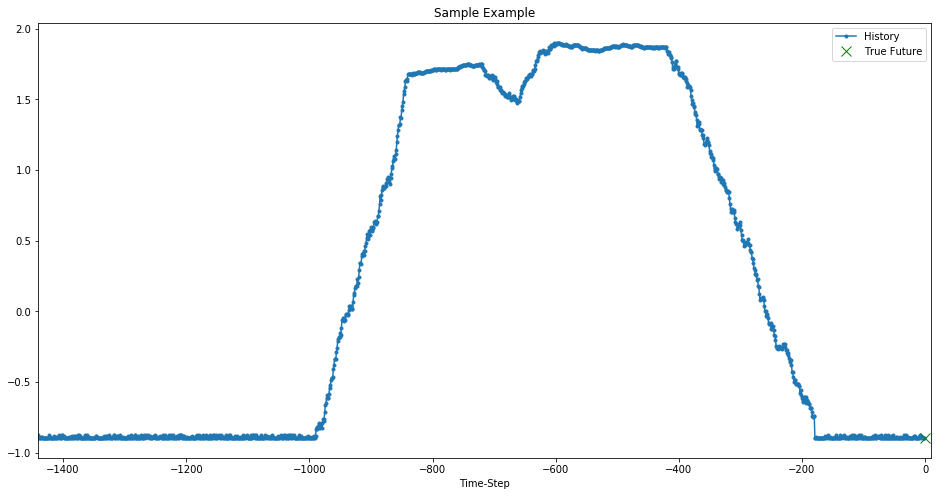

In [11]:
# for i in range(0, 1000, 100):

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

## Take Average of Last Day of Observations & Predict

In [12]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/einarnn/.virtualenvs/a/lib/python3.7/site-packages/matplotlib/pyplot.py'>

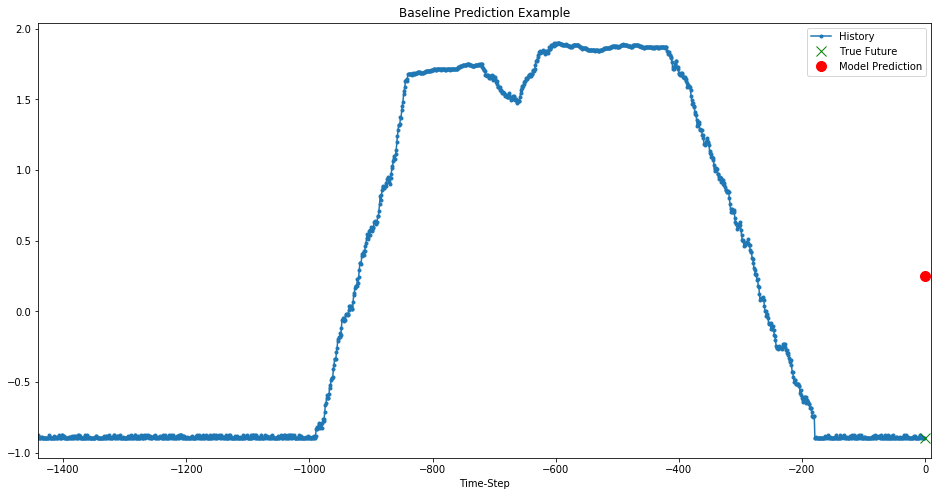

In [13]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

This is really not a very good prediction mechanism!!

## Recurrent Neural Network

In [14]:
print(x_train_uni.shape)
print(y_train_uni.shape)

(24480, 1440, 1)
(24480,)


In [15]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [16]:
#simple_lstm_model = tf.keras.models.Sequential([
#    tf.keras.layers.LSTM(8, return_sequences=True, input_shape=x_train_uni.shape[-2:]),
#    tf.keras.layers.LSTM(8),
#    tf.keras.layers.Dense(1)
#])
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [17]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [18]:
EVALUATION_INTERVAL = 100  # original 200
VALIDATION_STEPS    = 50   # original 50
EPOCHS              = 5    # original 5

history_lstm = simple_lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=EVALUATION_INTERVAL,
    validation_data=val_univariate,
    validation_steps=VALIDATION_STEPS)

Train for 100 steps, validate for 50 steps
Epoch 1/5
100/100 [==============================] - 54s 540ms/step - loss: 0.2614 - val_loss: 0.0935
Epoch 2/5
100/100 [==============================] - 56s 561ms/step - loss: 0.0798 - val_loss: 0.0503
Epoch 3/5
100/100 [==============================] - 59s 587ms/step - loss: 0.0568 - val_loss: 0.0427
Epoch 4/5
100/100 [==============================] - 56s 556ms/step - loss: 0.0522 - val_loss: 0.0400
Epoch 5/5
100/100 [==============================] - 58s 577ms/step - loss: 0.0499 - val_loss: 0.0382


In [19]:
simple_lstm_model.save_weights('save_lstm')

In [20]:
loaded_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, return_sequences=True, input_shape=x_train_uni.shape[-2:]),
#    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])
loaded_lstm_model.compile(optimizer='adam', loss='mae')
loaded_lstm_model.load_weights('save_lstm')

In [21]:
loaded_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1440, 8)           320       
_________________________________________________________________
dense_1 (Dense)              (None, 1440, 1)           9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for x, y in val_univariate.take(5):
    print(x)
    print(y)
    print('-'*20)
    #print(x[0].numpy().shape)
    #print(y[0].numpy())
    #print(simple_lstm_model.predict(x)[0])
    #print(simple_lstm_model.predict(x))

In [ ]:
for x, y in val_univariate.take(10):
    print(x[0].numpy().shape)
    print(y[0].numpy().shape)
    pred = simple_gru_model.predict(x)[0]
    plt.plot(pred, color='red')
    plt.plot(x[0].numpy(), color='blue')
    plt.show()
    #plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    #plot.show()

# Scratch Area

In [ ]:
dataset = df
start_index = 0
end_index = 1440 * 3
history_size = 1440
target_size = 0

data = []
labels = []

start_index = start_index + history_size
if end_index is None:
    end_index = len(dataset) - target_size

for i in range(start_index, end_index):
    print('i', i)
    indices = range(i-history_size, i)
    print('indices', indices)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])

np.array(data), np.array(labels)

In [ ]:
dataset['Time']